# HiggsML baseline solution

This code walks you through the baseline solution for higgs competition
1. Downloading the data
2. Preprocessing
3. Training model
4. Saving predictions

# 1. Loading the data
Just a simple bash script to load kaggle higgs dataset.

First run may take a few minutes to actually download the data from `opendata.cern.ch`.

In [1]:
%%bash
if [[ ! -f 'atlas-higgs-challenge-2014-v2.csv' ]]; then \
    echo "downloading dataset..."
    wget -c http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz ; \
    gunzip 'atlas-higgs-challenge-2014-v2.csv.gz' ; \
fi

In [2]:
#read as pandas dataframe
import pandas as pd
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [3]:
#a glimpse into the dataset
df[:10]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,b,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,s,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,s,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,b,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,s,t,0.001502


# 2. Preprocessing
- We apply a couple of standard data analysis techniques
  * Selecting the feature __(X)__, target __(y)__ and __weight__ columns 
  * Imputing missing values
  * Adding logarithmic features
  * Splitting data into training, test and validation sets


You may note that some of the features are redundant for the models we are going to use.
Nevertheless, they are computed so that you could jump to your own models quicker.

##### Selecting columns

In [4]:
import numpy as np
np.random.seed(1337)

In [5]:
#target column
y = df['Label'].values == 's'

#features
X_raw = df.iloc[:,1:31].values

#weights
weights = df['KaggleWeight'].values

#whether sample is in training or test set
dataset_mask = df["KaggleSet"].values

If you don't like the perspective of waiting that long each time, use 
* `X_imputed.to_csv("myfile.csv")` to save
* `X_imputed = pd.DataFrame.from_csv("myfile.csv")` to load

##### Logarithmic features
* Pick all strictly positive columns and add $ log(1 + v) $ transformations of these features.
* This has only a minor effect for tree methods used here, however it will simplify trying out other models.


In [6]:
#X columns with strictly positive features (selected manually)
positive_features = (0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26)

X_log = np.log(1 + X_raw[:,positive_features])
X_log[np.isnan(X_log)] = -999

X = np.hstack((X_raw, X_log))

##### Train/test split
* Split data into 3 sets: training, validation and the final test set 

In [7]:
Xtr,Ytr,Wtr = map(lambda v: v[dataset_mask=='t'], [X,y,weights])
Xval,Yval,Wval = map(lambda v: v[dataset_mask=='b'], [X,y,weights])
Xtest,Ytest,Wtest = map(lambda v: v[dataset_mask=='v'], [X,y,weights])

### Scale to equalize feature variances
* This too is hardly applicable to the tree ensembles, but other models may benefit from it.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Xtr)
Xtr,Xval,Xtest = map(scaler.transform, (Xtr,Xval,Xtest))

### Training model

Here we define and train a custom ensemble of decision trees.
* Namely, we use AdaBoost algorithm above Extremely Randomized Trees ensembles.

The idea behind [Extremely Randomized Trees](https://pdfs.semanticscholar.org/336a/165c17c9c56160d332b9f4a2b403fccbdbfb.pdf) is to spawn many weak decision trees using random subsamples of data and features, and than average them out in hope to get a quality above any individual tree.

[AdaBoost](http://rob.schapire.net/papers/explaining-adaboost.pdf), in it's turn, trains estimators sequentially, each new one laying more emphasis on the data samples that previous estimators had most problems with. This is done through iterative reweighting of data samples based on the ensemble score on these samples.


On each iteration of AdaBoost, we train not one, but several extremely randomized trees using AdaBoost-reweighted samples. We use the extremely randomized trees parallelism to spawn a lot of decision trees in less CPU time and AdaBoost steps to 'guide' the new trees to most important samples. 


We have taken initial inner model parameters from several Kaggle Higgs Boson Competition forum discussions and made a few steps with sheer gut feeling.
We have initialized AdaBoost params with numbers whispered by a weasel ghost, and after a few tweaks they turned out to work ~not too badly.

The final model has 300*20=6000 low-quality trees.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
# The inner Extremely Randomized Trees ensemble to be trained at each AdaBoost step
rf = ExtraTreesClassifier(
            n_estimators = 300,
            max_features = 30,
            max_depth = 12,
            min_samples_leaf = 100,
            min_samples_split = 100,
            verbose = 1,
            n_jobs = -1 #<- this flag allows to use all CPU cores available. Remove if you don't want that.
)

# The AdaBoost is defined here
classifier = AdaBoostClassifier(
        n_estimators = 20,
        learning_rate = 0.75,
        base_estimator = rf)

In [10]:
%%time
print "model fit"
classifier.fit(Xtr, Ytr, sample_weight = Wtr)

[Parallel(n_jobs=-1)]: Done   1 out of 300 | elapsed:    4.0s remaining: 19.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   28.8s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done   1 out of 300 | elapsed:    3.4s remaining: 16.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Done   1 out of  74 | elapsed:    0.1s remaining:    4.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of 300 | elapsed:    3.6s remaining: 18.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Done   1 out of 198 | elapsed:    0.1s remaining:   10.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of 300 | elapsed:    3.6s remaining: 18.1min
[Parall

model fit
CPU times: user 6h 35min 33s, sys: 35.5 s, total: 6h 36min 9s
Wall time: 25min 35s


# Evaluate AMS threshold
* Approximate Median significance is a threshold-dependent metric
* In other words, it requires you to assign "signal" vs "background" class, not just probabilities.
* To choose the best threshold for signal probability, we shall use a separate validation set.
* We use a simple grid search. If you want something bigger, go for [rep.metrics.OptimalAMS](https://yandex.github.io/rep/report.html#rep.report.metrics.OptimalAMS)

In [11]:
def ams(s, b, br=10.):
    """
    Regularized approximate median significance

    :param s: amount of signal passed
    :param b: amount of background passed
    :param br: regularization
    """
    radicand = 2 * ((s + b + br) * np.log(1.0 + s / (b + br)) - s)
    return np.sqrt(radicand)

In [12]:
#predict signal probabilities for validation set
Yval_proba = classifier.predict_proba(Xval)[:,1]

[Parallel(n_jobs=16)]: Done   1 out of  43 | elapsed:    0.1s remaining:    2.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done   1 out of 283 | elapsed:    0.1s remaining:   23.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 161 | elapsed:    0.0s remaining:    6.9s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 128 | elapsed:    0.0s remaining:    5.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   16.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   1 out of  17 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.0s remaining:   10.4s
[Parall

In [13]:
Yval_proba_sort = Yval_proba[np.argsort(Yval_proba)]
Yval_sort = Yval[np.argsort(Yval_proba)]
Wval_sort = Wval[np.argsort(Yval_proba)]

min_quantile = 0.0
max_quantile = 0.99

i_min = int(len(Yval_proba_sort)*min_quantile)
i_max = int(len(Yval_proba_sort)*max_quantile)

s = (Yval_sort[i_min:]*Wval_sort[i_min:]).sum()
b = ((1-Yval_sort[i_min:])*Wval_sort[i_min:]).sum()

ams_steps = [ams(s,b)]
for i in range(i_min+1,i_max):
    if Yval_sort[i]:
        s -=Wval_sort[i]
    else:
        b -=Wval_sort[i]
    ams_steps.append(ams(s,b))
    
quantiles = np.arange(i_min,i_max) / float( len(Yval))
optimal_quantile = quantiles[np.argmax(ams_steps)]

##### Plot AMS against cut percentile

Optimal quantile threshold: 0.84259
Optimal AMS: 3.78065210374


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


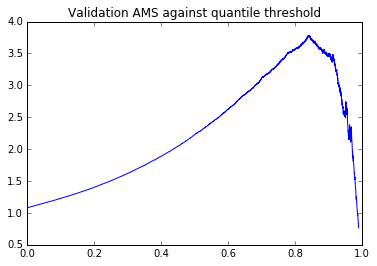

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(quantiles,ams_steps)
plt.title("Validation AMS against quantile threshold")
print "Optimal quantile threshold:",optimal_quantile
print "Optimal AMS:",np.max(ams_steps)

In [15]:
#Weasel(x)
optimal_quantile = 0.85

# Finally, score the test set
* Using only the parameters learned on training and test set

In [16]:
Ytest_proba = classifier.predict_proba(Xtest)[:,1]

[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   30.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   20.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Done   1 out of  12 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   24.7s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   21.9s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   20.8s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Done   1 out of 300 | elapsed:    0.1s remaining:   25.9s
[Parall

In [17]:
threshold = np.percentile(Ytest_proba,85)
print "Probability threshold for test:",threshold


Ytest_class = Ytest_proba >= threshold

Probability threshold for test: 0.444374490174


# Evaluate

In [18]:
selection_Y = Ytest[Ytest_class==1]
selection_weights = Wtest[Ytest_class==1]

s = selection_Y.dot(selection_weights)
b = (1 - selection_Y).dot(selection_weights)
print 's=',s,'b=',b
print "AMS =", ams(s,b)

s= 225.217927938 b= 3536.08772045
AMS = 3.74304782679
